<a href="https://colab.research.google.com/github/kaipak/ClassificationCompetition/blob/main/nbs/Sarcasm_Detector_kaiv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#!git clone https://github.com/kaipak/ClassificationCompetition.git drive/MyDrive/dev/ClassificationCompetition
!pip install transformers

Mounted at /content/drive


In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tensorboard

In [ ]:
import sys, os
from pathlib import Path
import random
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('drive/MyDrive/dev/ClassificationCompetition/src')
from model import SarcasmDetector
from data_prep import DataPrep

In [ ]:
!ls -l drive/MyDrive/dev/ClassificationCompetition

total 11088
-rw------- 1 root root    43649 Dec  7 16:00 answer.txt
drwx------ 2 root root     4096 Dec  7 16:00 data
-rw------- 1 root root      152 Dec  7 16:00 livedatalab_config.json
drwx------ 2 root root     4096 Dec  7 16:00 nbs
-rw------- 1 root root     2180 Dec  7 15:59 README.md
-rw------- 1 root root 11294523 Dec  7 16:00 SarcasmDetectionV3.ipynb
drwx------ 3 root root     4096 Dec  7 16:00 src


In [ ]:
repo_path = Path('drive/MyDrive/dev/ClassificationCompetition')
train_path = Path(repo_path / 'data/train.jsonl')
sub_path = Path(repo_path / 'data/test.jsonl')
output_path = Path(repo_path / 'data/output/')
input_path = Path(repo_path / 'data')
train_log_dir = Path( repo_path / 'data/logs/tensorboard/train')

In [ ]:
data_prepper = DataPrep(response_only=True, train_path=train_path, sub_path=sub_path)
data_prepper.train_test_split(random_state=255, test_size=.10)

0.1 test ratio results in 4500 training, 250 validation, and 250 test observations.


In [ ]:
data_prepper.df.head()

,label,text,context,concat
0,1,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...,@USER @USER @USER I don't get this .. obviousl...
1,1,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...,@USER @USER trying to protest about . Talking ...
2,1,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...,@USER @USER @USER He makes an insane about of ...
3,1,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...,@USER @USER Meanwhile Trump won't even release...
4,1,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...,@USER @USER Pretty Sure the Anti-Lincoln Crowd...


In [ ]:
data_prepper.df_sub.head()

,id,text,context,concat,label
0,twitter_1,"@USER @USER @USER My 3 year old , that just fi...","[Well now that ’ s problematic AF <URL>, @USER...","@USER @USER @USER My 3 year old , that just fi...",1
1,twitter_2,@USER @USER How many verifiable lies has he to...,[Last week the Fake News said that a section o...,@USER @USER How many verifiable lies has he to...,1
2,twitter_3,@USER @USER @USER Maybe Docs just a scrub of a...,[@USER Let ’ s Aplaud Brett When he deserves i...,@USER @USER @USER Maybe Docs just a scrub of a...,1
3,twitter_4,@USER @USER is just a cover up for the real ha...,[Women generally hate this president . What's ...,@USER @USER is just a cover up for the real ha...,1
4,twitter_5,@USER @USER @USER The irony being that he even...,"[Dear media Remoaners , you excitedly sharing ...",@USER @USER @USER The irony being that he even...,1


In [ ]:
data_prepper.write_data(datapath=output_path)

In [ ]:
detector = SarcasmDetector(tokenizer_do_lc=False, 
                           tokenizer_model='bert-base-uncased',
                           model_options_name='bert-base-uncased',
                           input_dir=input_path,
                           output_dir=output_path,
                           train_log_dir=train_log_dir)

There is/are 1 GPU(s) available.
GPU Tesla V100-SXM2-16GB will be used.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
%tensorboard --logdir drive/MyDrive/dev/ClassificationCompetition/data/logs/tensorboard/train

In [ ]:
detector.tokenize_data('train.csv', 'validate.csv', 'test.csv', batch_size=8, max_seq_len=128)

Created train, validation, and test datasets with max_seq_len=128
Created iterators with batch_size=8


In [ ]:
detector.train(num_epochs=16, lr=8e-7)

Epoch [1/15], Step [281/8445], Train Loss: 0.6766, Valid Loss: 0.7002
Model saved to ==> drive/MyDrive/dev/ClassificationCompetition/data/output/model.pt
Model saved to ==> drive/MyDrive/dev/ClassificationCompetition/data/output/metrics.pt
Epoch [1/15], Step [562/8445], Train Loss: 0.6923, Valid Loss: 0.7107
Epoch [2/15], Step [843/8445], Train Loss: 0.6964, Valid Loss: 0.6865
Model saved to ==> drive/MyDrive/dev/ClassificationCompetition/data/output/model.pt
Model saved to ==> drive/MyDrive/dev/ClassificationCompetition/data/output/metrics.pt
Epoch [2/15], Step [1124/8445], Train Loss: 0.6830, Valid Loss: 0.7109
Epoch [3/15], Step [1405/8445], Train Loss: 0.6885, Valid Loss: 0.6855
Model saved to ==> drive/MyDrive/dev/ClassificationCompetition/data/output/model.pt
Model saved to ==> drive/MyDrive/dev/ClassificationCompetition/data/output/metrics.pt
Epoch [3/15], Step [1686/8445], Train Loss: 0.6753, Valid Loss: 0.7162
Epoch [4/15], Step [1967/8445], Train Loss: 0.6882, Valid Loss: 0.6

Model loaded from drive/MyDrive/dev/ClassificationCompetition/data/output.


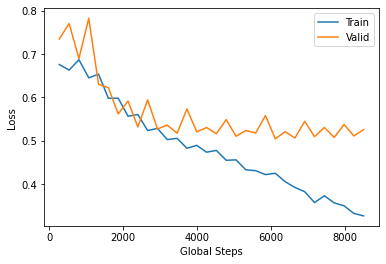

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = detector.load_metrics(output_path / 'metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

Model loaded from <== drive/MyDrive/dev/ClassificationCompetition/data/output/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.7198    0.7801    0.7487       191
           0     0.7500    0.6848    0.7159       184

    accuracy                         0.7333       375
   macro avg     0.7349    0.7324    0.7323       375
weighted avg     0.7346    0.7333    0.7326       375



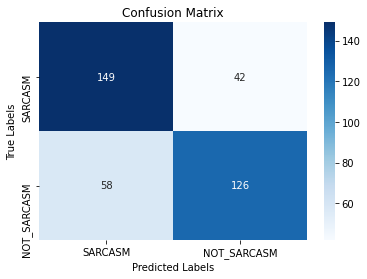

In [ ]:
detector.evaluate()

In [ ]:
df_sub = detector.predict(filepath=output_path / 'sub.csv')
df_sub.head()

Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors


Model loaded from <== drive/MyDrive/dev/ClassificationCompetition/data/output/model.pt


,id,label
0,twitter_1,NOT_SARCASM
1,twitter_2,NOT_SARCASM
2,twitter_3,NOT_SARCASM
3,twitter_4,NOT_SARCASM
4,twitter_5,NOT_SARCASM


In [ ]:
df_sub.to_csv(repo_path / 'answer.txt', header=False, index=False)

In [ ]:
print("[foo]")

[foo]
